In this assignment you are generating sample images of Simpsons with deep convolutional generative adversarial networks (DCGANs). 

You need to do the following:

1- Read and understand this tutorial: https://towardsdatascience.com/image-generator-drawing-cartoons-with-generative-adversarial-networks-45e814ca9b6b (Links to an external site.)Links to an external site.

2- Download the dataset and the source code (Jupyter Notebook) given in the tutorial. Analyze and understand the code. (Note: you need to work on images in the "cropped" folder in the dataset)

3- The code is implemented using Tensorflow. You need to change it to fully uses Keras. Please keep the structure of the code (name of the functions and so on) so it is easier to follow your code. 

4- Change the code to use resized images. The original images are 128x128 but you need to resize them to 64x64 before training. You need to make required adjustments in the network to accommodate this change. Thsi will make training faster too. 

5- Make sure you keep all the plotting parts of the code so you can observe how the system learns in each epoch. 

6- If training on Colab will be slow, you can only run it for 50 epochs (or as many as possible).  To test your code, you can run first one or two epochs. Once everything is working, then you can let it run for 50 or 300 epochs. 

7- If you wanted to run it faster, you can get free trials of GPU instances on AWS or Google cloud. 

8- Submit the notebook with all the results included in the notebook. 

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
# Hyperparameters
IMG_SIZE = 64
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 50 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 10
img_rows = 64
img_cols = 64
CHANNELS = 3
img_shape = (img_rows, img_cols, CHANNELS)

In [3]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    
    input_layer = Input(noise_shape)
    generator = Dense(1024*8*8, activation='relu')(input_layer)
    generator = Reshape((8, 8, 1024)) (generator)
    generator = LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=512, kernel_size=[5,5], padding="same",
                                             strides=[2,2], kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON) (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=256, kernel_size=[5,5], padding="same", strides=[2,2],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv2") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=128, kernel_size=[5,5], padding="same", strides=[2,2],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv3") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2)(generator)
    
    generator = keras.layers.Conv2DTranspose(filters=64, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv4") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
    
    generator = keras.layers.Conv2DTranspose(filters=3, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    out = Activation("tanh")(generator)
    
    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
  
    return model

In [4]:
def discriminatorFunction(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    
    input_layer = Input(img_shape)
    discriminator = Conv2D(filters = 64, kernel_size=[5,5],strides=[2,2],kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV), 
                             padding="SAME",input_shape = img_shape)(input_layer)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=128, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=256, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=512, kernel_size=[5,5], strides=[1,1], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=1024, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Flatten()(discriminator)

    out = Dense(1, activation='sigmoid')(discriminator)

    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
    
    return model

In [5]:
#print("Discriminator")
model_discriminator = discriminatorFunction(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
model_discriminator.compile(loss='binary_crossentropy',
                                    optimizer=Adam(lr=LR_D, beta_1=BETA1),
                                    metrics=['accuracy'])

W0911 18:08:44.245489 18000 deprecation_wrapper.py:119] From C:\Users\Asra Iqbal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0911 18:08:44.285480 18000 deprecation_wrapper.py:119] From C:\Users\Asra Iqbal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0911 18:08:44.293479 18000 deprecation_wrapper.py:119] From C:\Users\Asra Iqbal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0911 18:08:44.353465 18000 deprecation_wrapper.py:119] From C:\Users\Asra Iqbal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0911 18:08:44.353465 180

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

In [6]:
print("Generator")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 512)       0         


In [7]:
#build thwe Gan
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
model_discriminator.trainable = False #discriminator is not trainable for GANs
real = model_discriminator(img)
gan = Model(z, real)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1))
print("Model created based on Discriminator and Generator")
gan.summary()


Model created based on Discriminator and Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 3)         24036739  
_________________________________________________________________
model_1 (Model)              (None, 1)                 17439105  
Total params: 41,475,844
Trainable params: 24,034,819
Non-trainable params: 17,441,025
_________________________________________________________________


In [8]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMG_SIZE, IMG_SIZE))
    figure.set_size_inches(15,15)
    for index, axis in enumerate(axes):
        image_array = sample_images[index]
        axis.imshow(image_array)
    plt.tight_layout()
    plt.show()
    plt.close()

In [9]:
def summarize_epoch(d_losses, g_losses):
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.show()
    plt.close()

In [10]:
os.getcwd()

'C:\\Users\\Asra Iqbal\\GANs'

In [11]:
# Paths
INPUT_DATA_DIR = "C:/Users/Asra Iqbal/GANs/input/croppedd/" # Path to the folder with input images. For more info check simspons_dataset.txt
# OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
OUTPUT_DIR = ""

Start!
Input: (9877, 64, 64, 3)


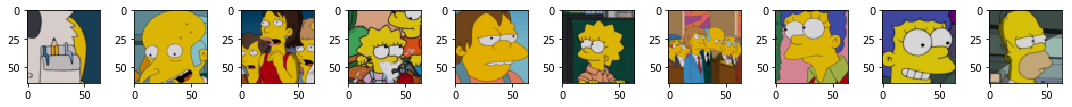

In [12]:
import warnings
warnings.filterwarnings("ignore")
import random
from scipy import ndimage, misc
# # Training
# INPUT_DATA_DIR = "../input/cropped/"
# OUTPUT_DIR = ""

exclude_img = ["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
"9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
"7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
"7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
"6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
"4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
"2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
"1702","1281","1272","772","736","737","691","684","314","242","191"]

exclude_img = [s + ".png" for s in exclude_img]

print("Start!")

import re

images = []

for filename in glob( INPUT_DATA_DIR + '*'):
    if filename not in exclude_img:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            image = ndimage.imread(filename, mode="RGB")
            image_resized = misc.imresize(image, (64, 64))
            images.append(np.array(image_resized))

images = np.array(images) / 255
#input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob( INPUT_DATA_DIR + '*')])
print ("Input: " + str(images.shape))

np.random.shuffle(images)


sample_images = random.sample(list(images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

In [13]:
# Adversarial ground truths
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

r, c = 4, 4
noise = np.random.normal(0, 1, (r*c, NOISE_SIZE))

In [14]:
#calculate steps per epoch
steps_per_epoch = len(images)//BATCH_SIZE
print("Training begins... Total epochs: {}, steps per epoch: {}".format(EPOCHS, steps_per_epoch))

Training begins... Total epochs: 50, steps per epoch: 154


In [15]:
steps_list = [x for x in range(steps_per_epoch)]

In [16]:
warnings.filterwarnings("ignore")
from tqdm import tqdm

d_loss_list = []
g_loss_list = []

for epoch in tqdm(range(EPOCHS)):
    epoch += 1 #start from 1
    # So, need to append d_loss, g_loss, and step to a dataframe with epoch as 
    
    for step in range(steps_per_epoch):
        step += 1 #start from 1

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, images.shape[0], BATCH_SIZE)
        imgs = images[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_SIZE))
        gen_imgs = model_generator.predict(noise)


        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = model_discriminator.train_on_batch(imgs, valid)
        d_loss_fake = model_discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train GAN
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = gan.train_on_batch(noise, valid)

        # Plot the progress
        print ("Epoch: {}/{} | Step: {}/{} [D loss: {:.4f}, acc.: {:.2f}%] [G loss: {:.4f}]".format(
                    epoch, EPOCHS, step, steps_per_epoch, d_loss[0], 100*d_loss[1], g_loss
                ))

        # Append d_loss, g_loss, and step to a dataframe
        #step_df = df.append({'d_loss' : d_loss[0], 'g_loss' : g_loss}, ignore_index=True)

        d_loss_zero = d_loss[0]

        d_loss_list.append(d_loss_zero)
        g_loss_list.append(g_loss)


  # Plot Loss
    summarize_epoch(d_loss_list,g_loss_list)

    # Plot images
    gen_imgs = model_generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()
  
    if epoch % 10 == 0:
        model_generator.save("g{}.h5".format(epoch))


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1/50 | Step: 1/154 [D loss: 1.5686, acc.: 27.34%] [G loss: 1.0312]
Epoch: 1/50 | Step: 2/154 [D loss: 2.3796, acc.: 50.00%] [G loss: 0.9390]
Epoch: 1/50 | Step: 3/154 [D loss: 1.9114, acc.: 43.75%] [G loss: 2.3930]
Epoch: 1/50 | Step: 4/154 [D loss: 1.8190, acc.: 19.53%] [G loss: 3.4198]
Epoch: 1/50 | Step: 5/154 [D loss: 1.8624, acc.: 19.53%] [G loss: 3.0966]
Epoch: 1/50 | Step: 6/154 [D loss: 1.5718, acc.: 27.34%] [G loss: 4.7615]
Epoch: 1/50 | Step: 7/154 [D loss: 1.0281, acc.: 45.31%] [G loss: 4.5242]
Epoch: 1/50 | Step: 8/154 [D loss: 0.6785, acc.: 60.16%] [G loss: 5.2796]
Epoch: 1/50 | Step: 9/154 [D loss: 0.7308, acc.: 58.59%] [G loss: 5.1627]
Epoch: 1/50 | Step: 10/154 [D loss: 0.6667, acc.: 67.97%] [G loss: 5.6987]
Epoch: 1/50 | Step: 11/154 [D loss: 0.7548, acc.: 56.25%] [G loss: 7.2496]
Epoch: 1/50 | Step: 12/154 [D loss: 0.5209, acc.: 74.22%] [G loss: 5.2328]
Epoch: 1/50 | Step: 13/154 [D loss: 0.6931, acc.: 64.06%] [G loss: 5.6757]
Epoch: 1/50 | Step: 14/154 [D loss

KeyboardInterrupt: 